# Load Libraries

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Common Tools
from sklearn.preprocessing import LabelEncoder
from collections import Counter

#Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble, tree, svm, naive_bayes, neighbors, linear_model, gaussian_process, neural_network
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from sklearn.ensemble import VotingClassifier

#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import Data

In [2]:
# import data
path = 'PATH'
data = pd.read_csv(path)
data

,date,星期,測站氣壓(hPa),氣溫(℃),風速(m/s),風向(360degree),降水量(mm),促銷檔期,週末,吉安鄉(Y/N)
0,2015/3/1,Sunday,1012.7,20.1,4.3,218,8.5,0,1,NaN
1,2015/3/2,Monday,1010.8,22.1,3.8,61,0.5,0,0,NaN
2,2015/3/3,Tuesday,1009.3,22.7,4.8,27,0.0,0,0,1.0
3,2015/3/4,Wednesday,1010.5,24.1,4.6,139,0.0,0,0,NaN
4,2015/3/5,Thursday,1011.3,23.3,6.4,33,0.0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
149,2015/8/27,Thursday,1003.5,25.1,1.8,208,50.5,0,0,NaN
150,2015/8/28,Friday,1005.8,25.3,2.2,159,54.0,0,0,1.0
151,2015/8/29,Saturday,1006.9,24.4,1.7,214,2.5,0,1,NaN
152,2015/8/30,Sunday,1009.0,25.1,2.5,222,33.5,0,1,NaN


# Data Preprocessing

In [3]:
# 刪除不要的行
columns = ['date', '星期']
data = data.drop(columns, axis = 1)

# 將NaN轉為0
data = data.fillna(0)

# 將'促銷檔期','週末'轉為類別型資料
data['促銷檔期'] = data['促銷檔期'].replace([0], "N")
data['促銷檔期'] = data['促銷檔期'].replace([1], "Y")

data['週末'] = data['週末'].replace([0], "N")
data['週末'] = data['週末'].replace([1], "Y")

# float轉為int
data['吉安鄉(Y/N)'] = data['吉安鄉(Y/N)'].astype(int)

## Get dummies & Declare feature vector and target variable

In [4]:
# Get dummies
data = pd.get_dummies(data)

# Declare feature vector and target variable
X = data.drop(['吉安鄉(Y/N)'], axis = 1)
y = data['吉安鄉(Y/N)']

# Train-Test split

In [5]:
# Splitting the dataset into the Training set and Testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

# Feature Scaling

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model

In [7]:
MLA = [
    ensemble.AdaBoostClassifier(random_state = 40),
    ensemble.GradientBoostingClassifier(random_state = 40),
    ensemble.RandomForestClassifier(random_state = 40),
    linear_model.LogisticRegression(random_state = 40),
    linear_model.LogisticRegressionCV(random_state = 40),
    neighbors.KNeighborsClassifier(),
    svm.SVC(probability=True),
    tree.DecisionTreeClassifier(random_state = 40),
    xgb.XGBClassifier(random_state = 40)
    ]

In [8]:
#Do some preperation for the loop
col = []
algorithms = pd.DataFrame(columns = col)
idx = 0

#Train and score algorithms
for a in MLA:
    
    a.fit(X_train, y_train)
    pred = a.predict(X_test)
    
    #四項指標
    acc = accuracy_score(y_test, pred) #Other way: a.score(X_test, y_test)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    #Cross Validation
    cv = cross_val_score(a, X, y, cv = 5).mean()
    
    # AUROC
    y_scores = a.predict_proba(X_test)
    y_scores = y_scores[:,1]
    auroc = roc_auc_score(y_test, y_scores)
    
    Alg = a.__class__.__name__
    
    algorithms.loc[idx, 'Algorithm'] = Alg
    algorithms.loc[idx, 'Accuracy'] = round(acc * 100, 2)
    algorithms.loc[idx, 'Precision'] = round(precision * 100, 2)
    algorithms.loc[idx, 'Recall'] = round(recall * 100, 2)
    algorithms.loc[idx, 'F1 Score'] = round(f1 * 100, 2)
    algorithms.loc[idx, 'CV Score'] = round(cv * 100, 2)
    algorithms.loc[idx, 'AUC Score'] = round(auroc * 100, 2)

    idx+=1

In [9]:
#Compare invidual models
algorithms.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
algorithms

,Algorithm,Accuracy,Precision,Recall,F1 Score,CV Score,AUC Score
3,LogisticRegression,70.21,72.09,93.94,81.58,65.51,65.58
4,LogisticRegressionCV,70.21,70.21,100.00,82.50,67.44,64.29
6,SVC,70.21,70.21,100.00,82.50,70.77,49.57
2,RandomForestClassifier,65.96,70.73,87.88,78.38,57.68,53.90
1,GradientBoostingClassifier,63.83,70.00,84.85,76.71,56.37,50.00
7,DecisionTreeClassifier,61.70,71.43,75.76,73.53,51.85,52.16
0,AdaBoostClassifier,59.57,68.42,78.79,73.24,51.89,44.70
5,KNeighborsClassifier,59.57,69.44,75.76,72.46,63.59,45.67
8,XGBClassifier,53.19,65.71,69.70,67.65,55.74,46.86


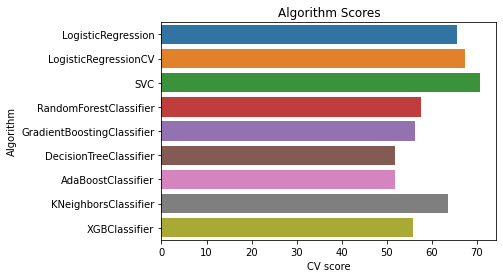

In [10]:
#Plot them
g = sns.barplot("CV Score", "Algorithm", data = algorithms)
g.set_xlabel("CV score")
g = g.set_title("Algorithm Scores")

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for clf in MLA:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print(name)
    
    # Confusion matrix
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('****Confusion matrix****\n', cm)
    
    print()
    
    # classification report
    cr = classification_report(y_test, y_pred)
    print('****Classification report****\n', cr)

AdaBoostClassifier
****Confusion matrix****
 [[ 2 12]
 [ 7 26]]

****Classification report****
               precision    recall  f1-score   support

           0       0.22      0.14      0.17        14
           1       0.68      0.79      0.73        33

    accuracy                           0.60        47
   macro avg       0.45      0.47      0.45        47
weighted avg       0.55      0.60      0.57        47

GradientBoostingClassifier
****Confusion matrix****
 [[ 2 12]
 [ 5 28]]

****Classification report****
               precision    recall  f1-score   support

           0       0.29      0.14      0.19        14
           1       0.70      0.85      0.77        33

    accuracy                           0.64        47
   macro avg       0.49      0.50      0.48        47
weighted avg       0.58      0.64      0.60        47

RandomForestClassifier
****Confusion matrix****
 [[ 2 12]
 [ 4 29]]

****Classification report****
               precision    recall  f1-score   

# Evaluation

## GS Parameter Tunning

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2', 'l1', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

print(lr.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [25]:
# Logistic Regression
LR = LogisticRegression()
lr_param = {
    #'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag','saga'],
    'C': [0.01, 0.1, 1, 10, 100, 1000]
    }

gsLR = GridSearchCV(LR, param_grid = lr_param, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)
gsLR.fit(X_train, y_train)
LR_best = gsLR.best_estimator_

# Best score
print()
print('Best Score : ', gsLR.best_score_)

# Best params
print('Best Params : ',gsLR.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits

Best Score :  0.6601190476190475
Best Params :  {'C': 0.1, 'solver': 'liblinear'}


In [30]:
pred = gsLR.predict(X_test)

acc = accuracy_score(y_test, pred) #Other way: vc.score(X_test, y_test)
f1 = f1_score(y_test, pred)
cv = cross_val_score(LR, X_train, y_train).mean()

print("Accuracy: ", round(acc*100,2), "\nF1-Score: ", round(f1*100,2), "\nCV Score: ", round(cv*100,2))

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, pred)
print('****Confusion matrix****\n', cm)
    
print()
    
# classification report
cr = classification_report(y_test, pred)
print('****Classification report****\n', cr)

# AUROC
y_scores = gsLR.predict_proba(X_test)
y_scores = y_scores[:,1]
auroc = roc_auc_score(y_test, y_scores)
print('****ROC AUC Score****\n', auroc)

Accuracy:  70.21 
F1-Score:  81.58 
CV Score:  66.28
****Confusion matrix****
 [[ 2 12]
 [ 2 31]]

****Classification report****
               precision    recall  f1-score   support

           0       0.50      0.14      0.22        14
           1       0.72      0.94      0.82        33

    accuracy                           0.70        47
   macro avg       0.61      0.54      0.52        47
weighted avg       0.66      0.70      0.64        47

****ROC AUC Score****
 0.6536796536796537


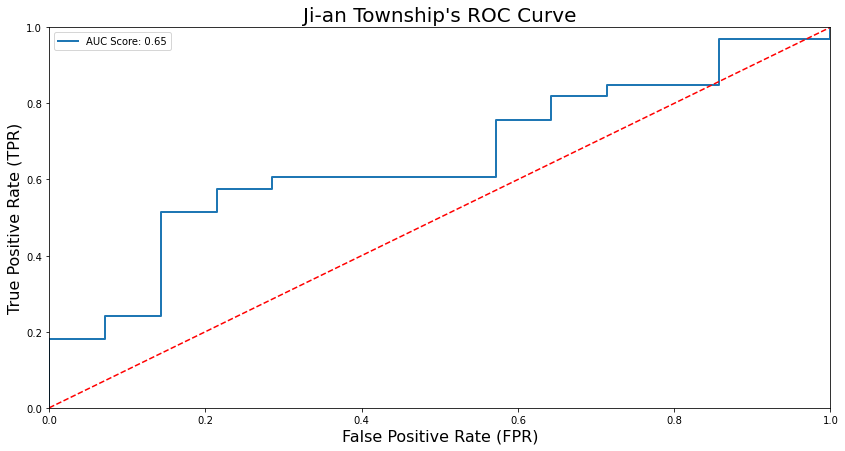

In [31]:
y_scores = gsLR.predict_proba(X_test)
y_scores = y_scores[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label='AUC Score: {:.2f}'.format(roc_auc_score(y_test, y_scores)))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.axis([0, 1, 0, 1])
    plt.title("Ji-an Township's ROC Curve", fontsize = 20)
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.legend()
    
plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)

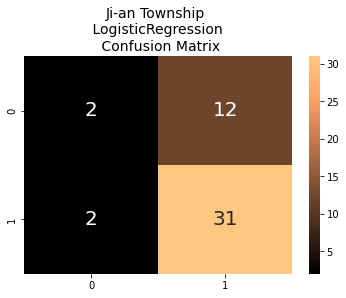

In [42]:
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.copper, annot_kws={"size":20})

plt.title("Ji-an Township \n LogisticRegression \n Confusion Matrix", fontsize=14)
plt.show()

## RS Parameter Tunning

In [39]:
# Logistic Regression
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

LR = LogisticRegression()
lr_param = {
    #'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag','saga'],
    #'C': stats.uniform(0.01, 1e4),
    'C': [0.01, 0.1, 1, 10, 100, 1000]
    }

from sklearn.model_selection import RandomizedSearchCV 

rsLR = RandomizedSearchCV(LR, param_distributions = lr_param, cv = 10, scoring = 'roc_auc',
                          n_iter=200, n_jobs = -1, verbose = 1)
rsLR.fit(X_train, y_train)
LR_best = rsLR.best_estimator_

# Best score
print()
print('Best Score : ', rsLR.best_score_)

# Best params
print('Best Params : ',rsLR.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits

Best Score :  0.6601190476190475
Best Params :  {'solver': 'liblinear', 'C': 0.1}


In [40]:
pred = rsLR.predict(X_test)

acc = accuracy_score(y_test, pred) #Other way: vc.score(X_test, y_test)
f1 = f1_score(y_test, pred)
cv = cross_val_score(LR, X_train, y_train).mean()

print("Accuracy: ", round(acc*100,2), "\nF1-Score: ", round(f1*100,2), "\nCV Score: ", round(cv*100,2))

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, pred)
print('****Confusion matrix****\n', cm)
    
print()
    
# classification report
cr = classification_report(y_test, pred)
print('****Classification report****\n', cr)

# AUROC
y_scores = rsLR.predict_proba(X_test)
y_scores = y_scores[:,1]
auroc = roc_auc_score(y_test, y_scores)
print('****ROC AUC Score****\n', auroc)

Accuracy:  70.21 
F1-Score:  81.58 
CV Score:  66.28
****Confusion matrix****
 [[ 2 12]
 [ 2 31]]

****Classification report****
               precision    recall  f1-score   support

           0       0.50      0.14      0.22        14
           1       0.72      0.94      0.82        33

    accuracy                           0.70        47
   macro avg       0.61      0.54      0.52        47
weighted avg       0.66      0.70      0.64        47

****ROC AUC Score****
 0.6536796536796537


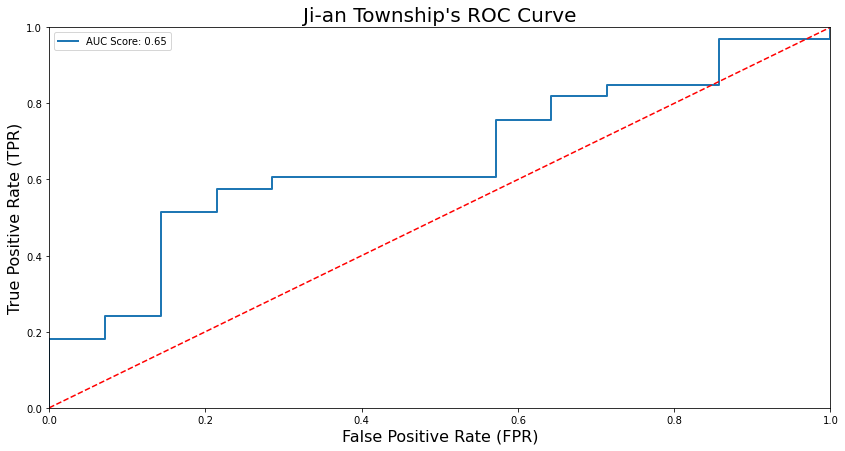

In [41]:
y_scores = rsLR.predict_proba(X_test)
y_scores = y_scores[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label='AUC Score: {:.2f}'.format(roc_auc_score(y_test, y_scores)))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.axis([0, 1, 0, 1])
    plt.title("Ji-an Township's ROC Curve", fontsize = 20)
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.legend()
    
plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)